# Image Search Based on a Natural Language Query Using CLIP Model

In this notebook, we implement a simople image search solution based on a natural language query using the CLIP model [1]. We use CLIP to pre-calculate embeddigns for images in a collection. For a given query, we calculate its embedding using CLIP and then search for the nearest neighbors in the collection of image embeddigns.

The implementation is based on [2].

### References
  1. https://openai.com/blog/clip/#rf33
  2. https://github.com/haltakov/natural-language-image-search
  
### Data
We use a small image collection available in the `tensorhouse-data` repository (`tensor-house-data/search/unspash-small`).

## Load the CLIP Model

In [ ]:
!pip install --upgrade git+https://github.com/openai/CLIP.git
!pip install boto3

In [4]:
import clip
import torch
import math
import numpy as np
import pandas as pd
import sys
import zipfile
import torchvision.models as models
from PIL import Image
import shutil
import os

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
from mpl_toolkits.axes_grid1 import ImageGrid

## Load CLIP Model

In [5]:

# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 82.5MiB/s]


## Process Input Images and Save Features

Images found: 316


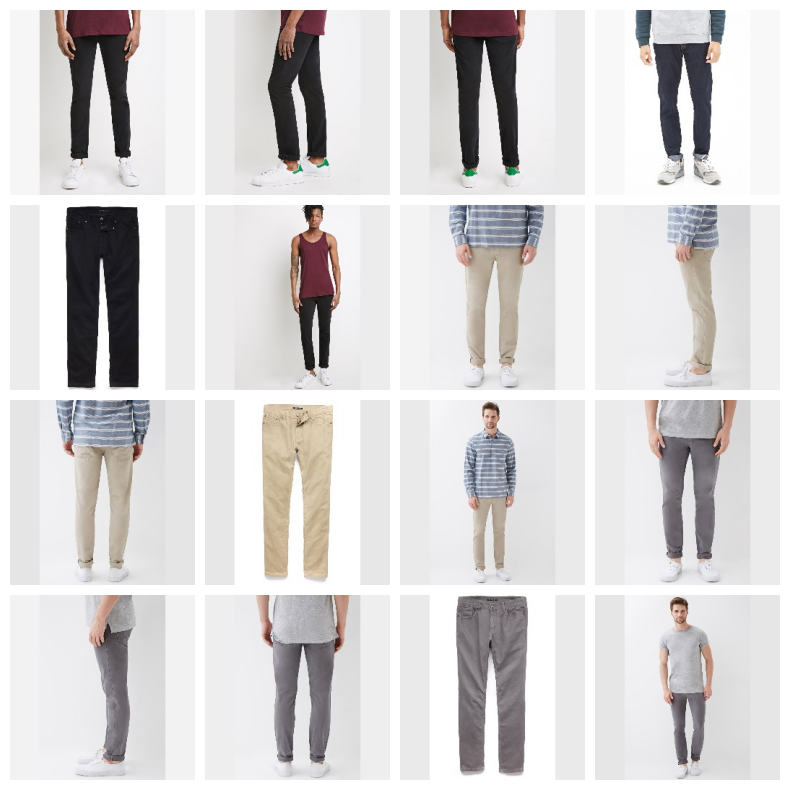

In [6]:
from pathlib import Path
import boto3
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Set your AWS credentials (replace 'your_access_key' and 'your_secret_key' with your actual AWS credentials)
aws_access_key_id = 'AWS_ACCESS_KEY_ID'
aws_secret_access_key = 'AWS_SECERT_ACCESS_KEY'

# Set the S3 bucket and folder path
s3_bucket_name = 'team3-ass3'
s3_folder_path = 'image'

# Create an S3 client
s3_client = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

# List all JPGs in the S3 folder
images_files = []

response = s3_client.list_objects(Bucket=s3_bucket_name, Prefix=s3_folder_path)
for obj in response.get('Contents', []):
    if obj['Key'].endswith('.jpg'):
        images_files.append(obj['Key'])

# Download images and store them in a list
image_data = []
for image_key in images_files:
    response = s3_client.get_object(Bucket=s3_bucket_name, Key=image_key)
    image_bytes = response['Body'].read()
    image_data.append(BytesIO(image_bytes))

# Print some statistics
print(f'Images found: {len(images_files)}')

# Display images
rows, columns = (4, 4)
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(rows, columns), axes_pad=0.1)

for ax, im_data in zip(grid, image_data[:rows * columns]):
    im = Image.open(im_data)
    ax.imshow(im)
    ax.axis('off')

plt.show()


In [7]:

# List all JPGs in the S3 folder
images_files = []

response = s3_client.list_objects(Bucket=s3_bucket_name, Prefix=s3_folder_path)
for obj in response.get('Contents', []):
    if obj['Key'].endswith('.jpg'):
        images_files.append(obj['Key'])

# Path where the feature vectors will be stored
features_path = Path(".") / "features"
if not features_path.exists():
    features_path.mkdir()

# Function that computes the feature vectors for a batch of images
def compute_clip_features(images_batch):
    # Load all the images from S3
    images = [Image.open(BytesIO(s3_client.get_object(Bucket=s3_bucket_name, Key=image_key)['Body'].read())) for image_key in images_batch]

    images_preprocessed = torch.stack([preprocess(image) for image in images]).to(device)

    with torch.no_grad():
        # Encode the images batch to compute the feature vectors and normalize them
        images_features = model.encode_image(images_preprocessed)
        images_features /= images_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return images_features.cpu().numpy()

# Define the batch size
batch_size = 16

# Compute how many batches are needed
batches = len(images_files) // batch_size + int(len(images_files) % batch_size != 0)

# Process each batch
for i in range(batches):
    print(f"Processing batch {i + 1}/{batches}")

    batch_ids_path = features_path / f"{i:010d}.csv"
    batch_features_path = features_path / f"{i:010d}.npy"

    # Only do the processing if the batch wasn't processed yet
    if not batch_features_path.exists():
        try:
            # Select the images for the current batch
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(images_files))
            batch_files = images_files[start_idx: end_idx]

            # Compute the features and save to a numpy file
            batch_features = compute_clip_features(batch_files)
            np.save(batch_features_path, batch_features)

            # Save the image IDs to a CSV file
            image_ids = [image_file.split(".jpg")[0].split("/")[-1] for image_file in batch_files]
            image_ids_data = pd.DataFrame(image_ids, columns=['image_id'])
            image_ids_data.to_csv(batch_ids_path, index=False)
        except Exception as e:
            # Catch problems with the processing to make the process more robust
            print(f'Problem with batch {i} {e}')

Processing batch 1/20
Processing batch 2/20
Processing batch 3/20
Processing batch 4/20
Processing batch 5/20
Processing batch 6/20
Processing batch 7/20
Processing batch 8/20
Processing batch 9/20
Processing batch 10/20
Processing batch 11/20
Processing batch 12/20
Processing batch 13/20
Processing batch 14/20
Processing batch 15/20
Processing batch 16/20
Processing batch 17/20
Processing batch 18/20
Processing batch 19/20
Processing batch 20/20


In [8]:
# Load all numpy files
features_list = [np.load(features_file, allow_pickle=True) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(features_path / "features.npy", features)

# Load all the image IDs
image_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
image_ids.to_csv(features_path / "image_ids.csv", index=False)

In [9]:
image_ids.head()

,image_id
0,01_1_front
1,01_2_side
2,01_3_back
3,01_4_full
4,01_6_flat


### Upload File to S3


In [10]:
session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
)

# Create an S3 client using the session
s3_client = session.client('s3')

# Specify the file paths for upload
features_file_path = features_path / "features.npy"
image_ids_file_path = features_path / "image_ids.csv"

# Specify the S3 object keys for upload
features_s3_key = "features.npy"
image_ids_s3_key = "image_ids.csv"

# Upload the files to S3
s3_client.upload_file(str(features_file_path), s3_bucket_name, features_s3_key)
s3_client.upload_file(str(image_ids_file_path), s3_bucket_name, image_ids_s3_key)

print(f"Files uploaded to S3 bucket: {s3_bucket_name}")

Files uploaded to S3 bucket: team3-ass3


### Testing code for search query given

In [15]:
# Load the image IDs
image_ids = pd.read_csv(features_path / 'image_ids.csv')
image_ids = list(image_ids['image_id'])

# Load the features vectors
image_features = np.load(features_path / 'features.npy')

# Convert features to Tensors: Float32 on CPU and Float16 on GPU
if device == "cpu":
    image_features = torch.from_numpy(image_features).float().to(device)
else:
    image_features = torch.from_numpy(image_features).to(device)

# Print some statistics
print(f"Images loaded: {len(image_ids)}")

Images loaded: 316


Red Trouser


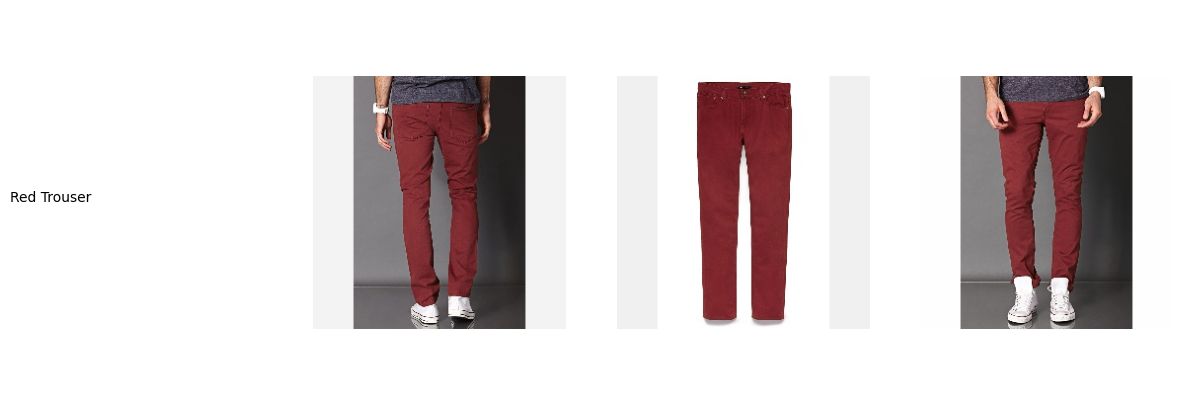

White Shirt


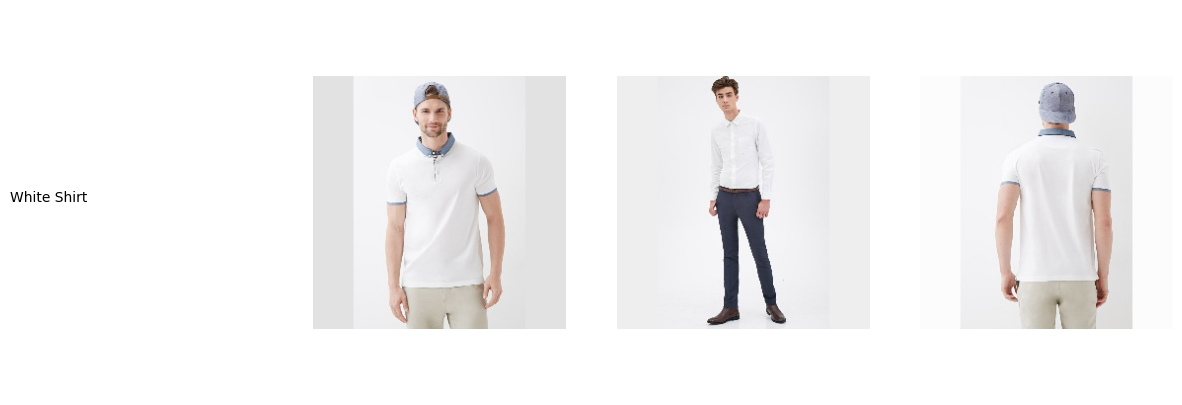

In [21]:
from urllib.parse import unquote
import boto3
from io import BytesIO

def encode_search_query(search_query):
    print(search_query)
    with torch.no_grad():
        # Encode and normalize the search query using CLIP
        text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
        text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

    # Retrieve the feature vector
    return text_encoded


def find_best_matches(text_features, image_features, image_ids, results_count=3):
    # Compute the similarity between the search query and each image using Cosine similarity
    similarities = (image_features @ text_features.T).squeeze(1)

    # Sort the images by their similarity score
    best_image_idx = (-similarities).argsort()

    # Return the image IDs of the best matches
    return [image_ids[i] for i in best_image_idx[:results_count]]

def download_image_from_s3(bucket_name, image_key, aws_access_key_id, aws_secret_access_key):
    s3 = boto3.client('s3', aws_access_key_id=unquote(aws_access_key_id), aws_secret_access_key=unquote(aws_secret_access_key))
    image_bytes = s3.get_object(Bucket=bucket_name, Key=image_key)['Body'].read()
    image = Image.open(BytesIO(image_bytes))
    return image

def search_and_display(search_query, image_features, image_ids, s3_bucket_name, aws_access_key_id, aws_secret_access_key, results_count=3):
    # Encode the search query
    text_features = encode_search_query(search_query)

    # Find the best matches
    result_image_ids = find_best_matches(text_features, image_features, image_ids, results_count)

    # Display the results
    fig, ax = plt.subplots(1, results_count + 1, figsize=(15, 5))
    ax[0].text(0.0, 0.5, search_query)
    ax[0].axis('off')

    for j, image_id in enumerate(result_image_ids):
        # Download the image from S3
        image_path = f'{s3_folder_path}/{image_id}.jpg'
        print(f"Downloading image from S3: {image_path}")
        image = download_image_from_s3(s3_bucket_name, image_path, aws_access_key_id, aws_secret_access_key)

        if image is not None:
            ax[j + 1].imshow(image)
            ax[j + 1].axis('off')

    plt.show()

search_queries = ['Red Trouser',
                  'White Shirt']

for search_query in search_queries:
    search_and_display(search_query, image_features, image_ids, s3_bucket_name, aws_access_key_id, aws_secret_access_key)
